In [1]:
#Module Imports and dataframe variables

import pandas as pd
import matplotlib as mlp
import geopandas as gpd
import fiona

crime_incidents = gpd.read_file(r"C:\Users\Kameron\Desktop\ArcGIS\Projects\MLK_River\Park_Improvements\Memphis_Open_Data\Memphis Police Department Public Safety Incidents\Memphis Police Department Public Safety Incidents\geo_export_734487dd-5817-4065-a934-db0bdea90ac8.shp")
Memphis_boundary = gpd.read_file(r"C:\Users\Kameron\Desktop\ArcGIS\Projects\MLK_River\Park_Improvements\TN_City_Boundaries\TN_City_Boundaries.shp", rows = slice(199, 200))
mlk_park = gpd.read_file(r"C:\Users\Kameron\Desktop\ArcGIS\Projects\MLK_River\Park_Improvements\Layer_Products.gdb", layer = "Kudzu_AOI")

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Fil

# Raw Tables

In [2]:
fiona.supported_drivers

{'ARCGEN': 'r',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'rw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

In [3]:
# Raw crime incidents
#fix points on null is land

crime_incidents.head()

,crime_id,date_offen,time_offen,agency_cri,city,state,coord1,coord2,masked_add,category,geometry
0,0601000621ME [44:083],2006-01-01,16:15:00.000,Simple Assault/DV,Memphis,TN,NaN,NaN,Winchester//Briar Park,Assault,None
1,0601001785ME [11:547],2006-01-03,22:50:00.000,Other Theft/Non-Specific,MEMPHIS,TN,NaN,NaN,LAMAR//KERR,Theft,None
2,0601003840ME [54:027],2006-01-08,21:15:00.000,Simple Assault,Memphis,TN,NaN,NaN,2300 Silver Creek,Assault,None
3,0601004197ME [57:540],2005-12-19,17:30:00.000,Identity Theft,Memphis,TN,NaN,NaN,8300 East Timbercreek,Theft,None
4,0601002320ME [52:277],2006-01-05,14:50:00.000,Drugs/Narcotics Violation/Misdemeanor,Memphis,TN,NaN,NaN,Randle//Henry,Drugs,None


In [4]:
#Shape data for MLK park 
mlk_park

,Shape_Length,Shape_Area,geometry
0,20733.902096,1.614027e+07,"MULTIPOLYGON (((749316.367 299832.230, 749028...."


In [5]:
#Shape Area of Memphis
Memphis_boundary

,OBJECTID,NAME,ShapeSTAre,ShapeSTLen,geometry
0,200,Memphis,8.396886e+09,748245.881488,"POLYGON ((844699.876 310913.066, 844694.434 31..."


## Geospatial Table Processing

In [6]:
#Ensure everything is in appropiate crs
crime_incidents = crime_incidents.to_crs(2274).clip(Memphis_boundary)
mlk_park = mlk_park.to_crs(2274)
Memphis_boundary = Memphis_boundary.to_crs(2274)

In [7]:
#Clip points to park 
crime_in_park = crime_incidents.clip(mlk_park)

In [8]:
#Clip points to 2 mi buffer. Buffers relies on crs units 
mlk_park_buffer = mlk_park.buffer(10560, resolution=16) #2 miles to feet

In [9]:
crime_outside_park = crime_incidents.clip(mlk_park_buffer)

### More specific table creation regarding crime incidents

#### MLK Park Table Manipulation 

In [10]:
#Just to keep track of original table fields
original_fields = ["crime_id", "date_offen", "time_offen", "agency_cri", "city", "state", "coord1", "coord2", "masked_add", "category", "geometry"]

In [11]:
#Crime by year. Derives year from date of offense
#Find a way to import data via API
#Use datetime to update year ranges for future proofing
crime_in_park = crime_in_park[["crime_id", "date_offen", "time_offen", "agency_cri", "city", "state", "coord1", "coord2", "masked_add", "category", "geometry"]]
crime_years = crime_in_park['date_offen'].values.tolist() #Will use to extract years as strings
crime_year_trans = []
for crime in crime_years:
    crime_year_trans.append(int(crime[0:4]))
crime_year_trans #List of integers that will be added to the geodataframe
year_def = {"year":crime_year_trans}
year_def #Dictionary that will be concatenated to crime geodataframe


year_def = pd.DataFrame(crime_year_trans).reset_index().rename(columns={0: "year"})

#Optained script idea to use values method from https://stackoverflow.com/questions/46396257/adding-a-new-column-in-pandas-dataframe-from-another-dataframe-with-differing-in
crime_in_park["year"] = year_def["year"].values
crime_in_park.head() #First derived table


,crime_id,date_offen,time_offen,agency_cri,city,state,coord1,coord2,masked_add,category,geometry,year
245410,1004008567ME [22:550],2010-04-15,17:00:00.000,MVT/Passenger Vehicle,Memphis,TN,35.108,-90.079,500 S Pkwy W,Theft of Vehicle,POINT (748760.595 307410.824),2010
1075862,0907012028ME [04:883],2009-07-18,08:00:00.000,Burglary/Non-Residential,Memphis,TN,35.108,-90.079,500 S Parkway W,Breaking & Entering,POINT (748760.595 307410.824),2009
366174,1205016507ME [10:227],2012-05-25,15:00:00.000,Burglary/Business,Memphis,TN,35.108,-90.079,500 South Pkwy West,Breaking & Entering,POINT (748760.595 307410.824),2012
1245777,1108003689ME [12:960],2011-08-06,02:16:00.000,Vandalism/Felony,Memphis,TN,35.108,-90.079,500 S Pkwy West,Property Crime,POINT (748760.595 307410.824),2011
1339189,0605002382ME [02:693],2006-05-04,15:00:00.000,Burglary/Business,Memphis,TN,35.108,-90.079,500 S Pkwy W,Breaking & Entering,POINT (748760.595 307410.824),2006


In [12]:
#Create a column to round time by hour

crimes_by_time = crime_in_park.copy()


crimes_time_type = pd.to_datetime(crimes_by_time["time_offen"]).reset_index()
crime_in_park['crime_hour'] = crimes_time_type['time_offen'].dt.round('H').dt.hour.values

# Derived code idea from https://stackoverflow.com/questions/31617845/how-to-select-rows-in-a-dataframe-between-two-values-in-python-pandas
crime_in_park = crime_in_park[crime_in_park['year'].between(2006, 2022)] #Data prior to 2006 seemed faulty, so I am narrowing the dataframe dates to time after 2005

crime_in_park

,crime_id,date_offen,time_offen,agency_cri,city,state,coord1,coord2,masked_add,category,geometry,year,crime_hour
245410,1004008567ME [22:550],2010-04-15,17:00:00.000,MVT/Passenger Vehicle,Memphis,TN,35.108,-90.079,500 S Pkwy W,Theft of Vehicle,POINT (748760.595 307410.824),2010,17
1075862,0907012028ME [04:883],2009-07-18,08:00:00.000,Burglary/Non-Residential,Memphis,TN,35.108,-90.079,500 S Parkway W,Breaking & Entering,POINT (748760.595 307410.824),2009,8
366174,1205016507ME [10:227],2012-05-25,15:00:00.000,Burglary/Business,Memphis,TN,35.108,-90.079,500 South Pkwy West,Breaking & Entering,POINT (748760.595 307410.824),2012,15
1245777,1108003689ME [12:960],2011-08-06,02:16:00.000,Vandalism/Felony,Memphis,TN,35.108,-90.079,500 S Pkwy West,Property Crime,POINT (748760.595 307410.824),2011,2
1339189,0605002382ME [02:693],2006-05-04,15:00:00.000,Burglary/Business,Memphis,TN,35.108,-90.079,500 S Pkwy W,Breaking & Entering,POINT (748760.595 307410.824),2006,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
791436,2108003328ME [33:600],2021-08-08,18:00:00.000,Weapon Law Violations/Misdemeanor,Memphis,TN,35.088,-90.083,500 W Mallory Ave,Weapons Offense,POINT (747261.547 300187.146),2021,18
932901,1911007444ME [08:140],2019-11-17,13:40:00.000,Drugs/Narcotics Violation/Misdemeanor,Memphis,TN,35.089,-90.083,500 E Mallory Ave,Drugs,POINT (747276.728 300550.824),2019,14
797668,2108003359ME [06:463],2021-08-08,19:19:00.000,Drugs/Narcotics Violation/Misdemeanor,Memphis,TN,35.089,-90.084,500 W Mallory Ave,Drugs,POINT (746977.802 300563.304),2021,19
881201,2008006540ME [07:397],2020-08-16,17:00:00.000,Drugs/Narcotics Violation/Felony,Memphis,TN,35.089,-90.084,500 W Mallory Ave,Drugs,POINT (746977.802 300563.304),2020,17


#### Crime 2 miles away from park

In [13]:
#Crime by year. Derives year from date of offense
crime_outside_park = crime_outside_park[["crime_id", "date_offen", "time_offen", "agency_cri", "city", "state", "coord1", "coord2", "masked_add", "category", "geometry"]]
crime_years = crime_outside_park['date_offen'].values.tolist() #Will use to extract years as strings
crime_year_trans = []
for crime in crime_years:
    crime_year_trans.append(int(crime[0:4]))
crime_year_trans #List of integers that represent years from date_offen that will be added to the geodataframe
year_def = {"year":crime_year_trans}
year_def #Dictionary that will be concatenated to crime geodataframe


year_def = pd.DataFrame(crime_year_trans).reset_index().rename(columns={0: "year"})

#Optained script idea to use values method from https://stackoverflow.com/questions/46396257/adding-a-new-column-in-pandas-dataframe-from-another-dataframe-with-differing-in
crime_outside_park["year"] = year_def["year"].values
crime_outside_park = crime_outside_park[crime_outside_park['year'].between(2006, 2022)] #Data prior to 2006 seemed faulty, so I am narrowing the dataframe dates to time after 2005. For instance, crime at 2005 and older was under 100 incidents
crime_outside_park.head() #First derived table


,crime_id,date_offen,time_offen,agency_cri,city,state,coord1,coord2,masked_add,category,geometry,year
56437,0608012768ME [06:513],2006-08-22,20:30:00.000,Theft from Motor Vehicle,Memphis,TN,35.134,-90.063,Tennessee Near Mina,Theft from Vehicle,POINT (753935.084 316667.495),2006
950240,2005011012ME [09:537],2020-05-28,08:30:00.000,Theft from Building,Memphis,TN,35.134,-90.063,500 Tennessee St,Theft,POINT (753935.084 316667.495),2020
690388,1903013862ME [09:463],2019-03-29,16:00:00.000,Threatening Phone Call,Memphis,TN,35.134,-90.063,500 Tennessee St,Assault,POINT (753935.084 316667.495),2019
785631,2011008845ME [05:713],2020-11-20,15:30:00.000,MVT/Passenger Vehicle,Memphis,TN,35.134,-90.063,500 Monteigne Blvd,Theft of Vehicle,POINT (753935.084 316667.495),2020
1462676,1805010435ME [16:243],2018-05-18,23:00:00.000,Vandalism/Felony,Memphis,TN,35.134,-90.063,600 Tennessee St,Property Crime,POINT (753935.084 316667.495),2018


In [14]:
#Create a column to round time by hour

crimes_by_time = crime_outside_park.copy()


crimes_time_type = pd.to_datetime(crimes_by_time["time_offen"]).reset_index()
crime_outside_park['crime_hour'] = crimes_time_type['time_offen'].dt.round('H').dt.hour.values
del(crimes_by_time)
crime_outside_park.head()

,crime_id,date_offen,time_offen,agency_cri,city,state,coord1,coord2,masked_add,category,geometry,year,crime_hour
56437,0608012768ME [06:513],2006-08-22,20:30:00.000,Theft from Motor Vehicle,Memphis,TN,35.134,-90.063,Tennessee Near Mina,Theft from Vehicle,POINT (753935.084 316667.495),2006,20
950240,2005011012ME [09:537],2020-05-28,08:30:00.000,Theft from Building,Memphis,TN,35.134,-90.063,500 Tennessee St,Theft,POINT (753935.084 316667.495),2020,8
690388,1903013862ME [09:463],2019-03-29,16:00:00.000,Threatening Phone Call,Memphis,TN,35.134,-90.063,500 Tennessee St,Assault,POINT (753935.084 316667.495),2019,16
785631,2011008845ME [05:713],2020-11-20,15:30:00.000,MVT/Passenger Vehicle,Memphis,TN,35.134,-90.063,500 Monteigne Blvd,Theft of Vehicle,POINT (753935.084 316667.495),2020,16
1462676,1805010435ME [16:243],2018-05-18,23:00:00.000,Vandalism/Felony,Memphis,TN,35.134,-90.063,600 Tennessee St,Property Crime,POINT (753935.084 316667.495),2018,23


### Geodataframe manipulation

#### MLK Riverside Park

In [15]:
#Table showing crime by year.
mlk_crime_by_year = crime_in_park[["time_offen","agency_cri","year"]].groupby(["year", "agency_cri"]).count().rename(columns={"time_offen": "crime_count"}).sort_values("year", ascending=False)
mlk_crime_by_year

crime_count
year agency_cri                                        
2021 Weapon Law Violations/Misdemeanor                5
     Traffic/Misc.                                    1
     MVT/Passenger Vehicle                            1
     Drugs/Narcotics Violation/Misdemeanor            4
     Drug Equipment Violation                         1
...                                                 ...
2006 Theft from Motor Vehicle                         2
     Robbery/Individual                               1
     Kidnapping/Abduction                             1
     Vandalism/Misdemeanor                            1
     Burglary/Business                                2

[78 rows x 1 columns]

In [16]:
#Total crimes in park by year

mlk_crime_by_year = crime_in_park[["year", "agency_cri"]].groupby("year").count().rename(columns={"agency_cri": "crime_count"}).sort_values("year", ascending=False)
mlk_crime_by_year.head()

,crime_count
year,
2021,12
2020,15
2019,12
2018,5
2017,11


In [17]:
#Crime by hours of the day within park
mlk_crime_by_hour = crime_in_park[["crime_hour","agency_cri"]].groupby(["crime_hour"]).count().rename(columns={"agency_cri": "crime_count"}).sort_values("crime_hour", ascending=True)
mlk_crime_by_hour.head()

,crime_count
crime_hour,
0,7
1,4
2,1
4,1
5,1


### Crime 2 miles away from park and within park

In [19]:
#Table showing crime by year  within two miles from park. 
two_mi_crime_by_year = crime_outside_park[["time_offen","agency_cri","year"]].groupby(["year", "agency_cri"]).count().rename(columns={"time_offen": "crime_count"}).sort_values("year", ascending=False)
two_mi_crime_by_year

crime_count
year agency_cri                                    
2022 Weapon Law Violations/Misdemeanor           13
     Drunkenness                                  4
     Other Theft/Scrap Metal                      1
     Other Theft/Non-Specific                    33
     Murder                                       4
...                                             ...
2006 Shoplifting/Misdemeanor                    177
     Shoplifting/Felony                           7
     Robbery/Individual                         175
     Robbery/Business                            31
     Aggravated Assault                         294

[963 rows x 1 columns]

In [20]:
#Total crimes by year within 2 miles from park

two_mi_crime_by_year = crime_outside_park[["year", "agency_cri"]].groupby("year").count().rename(columns={"agency_cri": "crime_count"}).sort_values("year", ascending=False)
two_mi_crime_by_year.head()

,crime_count
year,
2022,1184
2021,3978
2020,3865
2019,4055
2018,3501


In [21]:
#Crime by hours of the day within two miles from park
two_mi_crime_by_hour = crime_outside_park[["crime_hour","agency_cri"]].groupby(["crime_hour"]).count().rename(columns={"agency_cri": "crime_count"}).sort_values("crime_hour", ascending=True)
two_mi_crime_by_hour.head()

,crime_count
crime_hour,
0,3730
1,1892
2,2126
3,1313
4,1437


In [40]:
#Crime type by hour of day within two miles from park
two_mi_crime_type_time = crime_outside_park[["year","crime_hour","agency_cri"]].copy()
two_mi_crime_type_time = two_mi_crime_type_time.groupby(["year","crime_hour" ,"agency_cri"]).agg(crime_incidents=pd.NamedAgg(column="agency_cri", aggfunc="count")).reset_index()
two_mi_crime_type_time.sort_values("year", ascending=True)

,year,crime_hour,agency_cri,crime_incidents
0,2006,0,Aggravated Assault,18
520,2006,16,Other Theft/Scrap Metal,2
521,2006,16,Possible Stolen MVT,2
522,2006,16,Robbery/Business,1
523,2006,16,Robbery/Individual,13
...,...,...,...,...
11354,2022,9,Violation of Protection Order,1
11353,2022,9,Vandalism/Misdemeanor,7
11352,2022,9,Threatening Phone Call,1
11364,2022,10,Identity Theft,1


In [48]:
#Provides crime incidents by type and throughout the year that are within two miles from the park
two_mi_crimeType_inc = two_mi_crime_type_time.groupby(["year" ,"agency_cri"]).agg(crime_incidents=pd.NamedAgg(column="agency_cri", aggfunc="count")).reset_index()
two_mi_crimeType_inc

,year,agency_cri,crime_incidents
0,2006,Aggravated Assault,24
1,2006,Aggravated Assault/DV,23
2,2006,Arson,10
3,2006,Burglary/Business,24
4,2006,Burglary/Non-Residential,12
...,...,...,...
958,2022,Vandalism/Felony,14
959,2022,Vandalism/Misdemeanor,24
960,2022,Violation of Protection Order,2
961,2022,Weapon Law Violations/Felony,15


In [49]:
#Provides times that crimes occured within two miles of park
two_mi_hour_crime = two_mi_crime_type_time.groupby(["crime_hour" ,"agency_cri"]).agg(crime_incidents=pd.NamedAgg(column="agency_cri", aggfunc="count")).reset_index()
two_mi_hour_crime

,crime_hour,agency_cri,crime_incidents
0,0,Aggravated Assault,17
1,0,Aggravated Assault/DV,15
2,0,Arson,12
3,0,Burglary/Business,16
4,0,Burglary/Non-Residential,3
...,...,...,...
1340,23,Vandalism/Misdemeanor,17
1341,23,Violation of Protection Order,5
1342,23,Weapon Law Violations/Felony,7
1343,23,Weapon Law Violations/Misdemeanor,11


In [60]:
#A pivot table that's designed to make bar graphs with crime_hour on x axis and agency_cr on y axis
format_for_bar1_crimetype_hour = two_mi_crime_type_time.pivot_table(index = "crime_hour",columns = "agency_cri",values = "crime_incidents", aggfunc="sum")
format_for_bar1_crimetype_hour

agency_cri,Aggravated Assault,Aggravated Assault/DV,Arson,Burglary/Business,Burglary/Non-Residential,Burglary/Non-residential,Burglary/Residential,Carjacking,Disorderly Conduct,Driving Under the Influence,...,Threatening Phone Call/DV,Traffic/Misc.,Trespass of Real Property,Vandalism/Felony,Vandalism/Misdemeanor,Violation of Protection Order,Weapon Law Violations/Felony,Weapon Law Violations/Misdemeanor,Welfare Fraud,Wire Fraud
crime_hour,,,,,,,,,,,,,,,,,,,,,
0,230.0,115.0,37.0,107.0,3.0,45.0,160.0,20.0,4.0,27.0,...,3.0,1.0,12.0,104.0,485.0,13.0,15.0,26.0,1.0,2.0
1,151.0,51.0,27.0,78.0,1.0,12.0,79.0,15.0,1.0,23.0,...,1.0,NaN,5.0,70.0,237.0,8.0,16.0,11.0,NaN,NaN
2,133.0,68.0,40.0,113.0,2.0,19.0,80.0,14.0,1.0,28.0,...,2.0,NaN,4.0,56.0,294.0,6.0,9.0,13.0,NaN,NaN
3,69.0,32.0,25.0,104.0,1.0,12.0,60.0,9.0,NaN,28.0,...,2.0,NaN,4.0,53.0,211.0,5.0,3.0,7.0,NaN,NaN
4,61.0,40.0,32.0,100.0,3.0,6.0,98.0,15.0,2.0,22.0,...,1.0,NaN,5.0,55.0,222.0,6.0,5.0,7.0,NaN,NaN
5,29.0,16.0,14.0,51.0,1.0,10.0,95.0,3.0,1.0,8.0,...,2.0,NaN,4.0,26.0,109.0,2.0,7.0,2.0,NaN,NaN
6,36.0,30.0,24.0,34.0,4.0,14.0,214.0,8.0,NaN,8.0,...,3.0,NaN,3.0,37.0,164.0,7.0,4.0,1.0,NaN,NaN
7,29.0,35.0,12.0,21.0,1.0,10.0,255.0,3.0,NaN,7.0,...,1.0,NaN,2.0,47.0,181.0,5.0,7.0,3.0,NaN,NaN
8,65.0,53.0,16.0,46.0,8.0,22.0,499.0,2.0,5.0,4.0,...,8.0,NaN,9.0,58.0,283.0,7.0,17.0,11.0,NaN,NaN


In [61]:
#A pivot table that's designed to make bar graphs with year on x axis and agency_cr on y axis
format_for_bar2_crime_type_year = two_mi_crime_type_time.pivot_table(index = "year",columns = "agency_cri",values = "crime_incidents", aggfunc="sum")
format_for_bar2_crime_type_year

agency_cri,Aggravated Assault,Aggravated Assault/DV,Arson,Burglary/Business,Burglary/Non-Residential,Burglary/Non-residential,Burglary/Residential,Carjacking,Disorderly Conduct,Driving Under the Influence,...,Threatening Phone Call/DV,Traffic/Misc.,Trespass of Real Property,Vandalism/Felony,Vandalism/Misdemeanor,Violation of Protection Order,Weapon Law Violations/Felony,Weapon Law Violations/Misdemeanor,Welfare Fraud,Wire Fraud
year,,,,,,,,,,,,,,,,,,,,,
2006,294.0,124.0,19.0,275.0,15.0,33.0,551.0,27.0,NaN,6.0,...,4.0,NaN,NaN,206.0,547.0,5.0,23.0,36.0,NaN,1.0
2007,304.0,134.0,33.0,208.0,4.0,30.0,593.0,22.0,NaN,10.0,...,3.0,NaN,NaN,203.0,477.0,9.0,19.0,53.0,NaN,NaN
2008,271.0,135.0,40.0,201.0,10.0,43.0,549.0,20.0,NaN,45.0,...,4.0,NaN,NaN,134.0,509.0,16.0,18.0,70.0,1.0,1.0
2009,244.0,148.0,31.0,116.0,9.0,35.0,442.0,19.0,NaN,31.0,...,7.0,NaN,4.0,124.0,400.0,20.0,21.0,57.0,NaN,NaN
2010,206.0,120.0,27.0,112.0,2.0,15.0,391.0,14.0,4.0,38.0,...,8.0,NaN,8.0,112.0,364.0,24.0,28.0,45.0,NaN,NaN
2011,208.0,124.0,44.0,149.0,4.0,46.0,483.0,6.0,12.0,49.0,...,15.0,NaN,11.0,139.0,536.0,18.0,32.0,31.0,NaN,NaN
2012,246.0,99.0,37.0,87.0,8.0,24.0,393.0,10.0,9.0,38.0,...,16.0,NaN,9.0,144.0,396.0,4.0,18.0,37.0,NaN,1.0
2013,9.0,5.0,1.0,6.0,NaN,NaN,24.0,NaN,1.0,2.0,...,NaN,NaN,NaN,5.0,21.0,2.0,3.0,4.0,NaN,NaN
2014,86.0,36.0,13.0,47.0,NaN,10.0,160.0,7.0,1.0,21.0,...,1.0,3.0,7.0,49.0,161.0,9.0,13.0,7.0,NaN,NaN


# Maps

### General Area

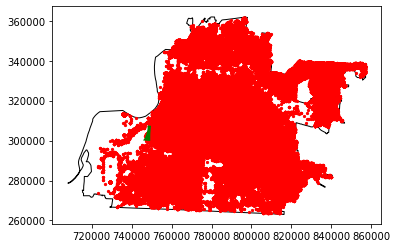

In [63]:
'''Makes a small scale map to show abundance of crime incidents in Memphis TN. The lack of points to the left of
the park is due to a river. This can be seen when looking at imagery'''

memphis_base = Memphis_boundary.plot(color='white', edgecolor='black', zorder = 1) #Value assigned to variable must be provided along with layers
crime_incidents.plot(ax=memphis_base, marker='o', color='red', markersize=5, zorder=2);
mlk_park.plot(ax=memphis_base, marker='o', color='green', markersize=5, zorder = 3);


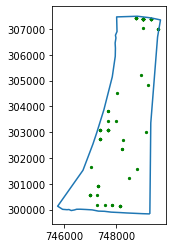

In [24]:
#Plots a map of crimes within the park according to coordinates
mlk_park_boundary = mlk_park.boundary.plot(zorder = 2)
crime_in_park.plot(ax=mlk_park_boundary, marker='o', color='green', markersize=5, zorder = 1);

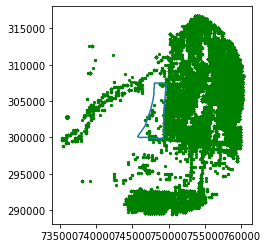

In [25]:
#Plots incidents of crime that are within 2 miles of the park and within the park
mlk_park_boundary = mlk_park.boundary.plot(zorder = 2)
crime_2mi = crime_outside_park.plot(ax=mlk_park_boundary, marker='o', color='green', markersize=5, zorder = 1);

## Graphs

##### To do

## Data Exports

In [62]:
#Convert geodataframe to excel spreadsheets
with pd.ExcelWriter(r'C:\Users\Kameron\Desktop\ArcGIS\Projects\MLK_River\Park_Improvements\Pandas_Analysis.xlsx') as writer:  

    two_mi_crime_type_time.to_excel(writer, sheet_name='two_mi_crime_type_time')
    two_mi_crime_by_hour.to_excel(writer, sheet_name='two_mi_crime_by_hour')
    two_mi_crime_by_year.to_excel(writer, sheet_name='two_mi_crime_by_year')
    mlk_crime_type_time.to_excel(writer, sheet_name='mlk_crime_type_time')
    mlk_crime_by_hour.to_excel(writer, sheet_name='mlk_crime_by_hour')
    two_mi_crimeType_inc.to_excel(writer, sheet_name='two_mi_crimeType_inc')
    two_mi_hour_crime.to_excel(writer, sheet_name='two_mi_crimeType_inc')
    format_for_bar1_crimetype_hour.to_excel(writer, sheet_name='format_for_bar1_crimetype_hour')  #Make a function that produces a graph and chart based on the year given 
    format_for_bar2_crime_type_year.to_excel(writer, sheet_name='format_for_bar2_crime_type_year')

In [27]:
#Convert to geodatabase feature class or shapefile

crime_in_park.to_file(r"C:\Users\Kameron\Desktop\ArcGIS\Projects\MLK_River\Park_Improvements\Pandas", layer="crime_in_park")
crime_outside_park.to_file(r"C:\Users\Kameron\Desktop\ArcGIS\Projects\MLK_River\Park_Improvements\Pandas", layer="crime_outside_park")

C:\Users\Kameron\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\Kameron\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
